In [1]:
import cv2
import numpy as np
import skimage.io as si
import skimage.color as sc
import matplotlib.pyplot as plt

## 1. Another `color-spaces`
### 1.1 Another `color-spaces` in `OpenCV`

In [2]:
cv2_color_flag = [flag for flag in dir(cv2) if flag.startswith('COLOR_')]
print(len(cv2_color_flag))
print(cv2_color_flag[:10])

274
['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR']


### 1.2. In `skimage.color`

In [3]:
sc_color_flag = [flag for flag in dir(sc) if '2' in flag]
print(len(sc_color_flag))
print(sc_color_flag[:10])

36
['deltaE_ciede2000', 'gray2rgb', 'gray2rgba', 'grey2rgb', 'hed2rgb', 'hsv2rgb', 'lab2lch', 'lab2rgb', 'lab2xyz', 'label2rgb']


## 2. Some examples.
### 2.1. `COLOR_RGB2GRAY` and `rgb2gray`

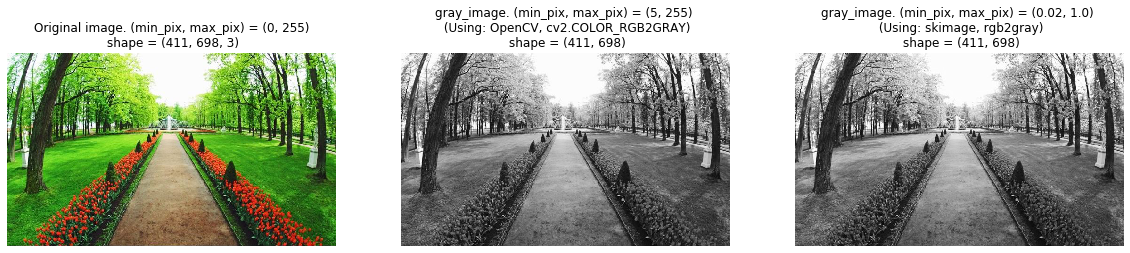

In [4]:
path = r"C:\Users\Admin\Desktop\mang.jpg"
im = si.imread(path)
images = [im, cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), sc.rgb2gray(im)]
cmaps = ['gray', 'gray', 'gray']
titles = ['Original image. (min_pix, max_pix) = (%s, %s)'
          %(images[0].min(), images[0].max() ), 
          'gray_image. (min_pix, max_pix) = (%s, %s) \n (Using: OpenCV, cv2.COLOR_RGB2GRAY)'
          %(images[1].min(), images[1].max()), 
          'gray_image. (min_pix, max_pix) = (%.2f, %.1f) \n (Using: skimage, rgb2gray)'
          %(images[2].min(), images[2].max())]

plt.figure(figsize = (20, 6))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(images[k], cmap = cmaps[k])
    plt.title(titles[k] + '\n shape = ' + str(images[k].shape))
    plt.axis("off")

Now, we will verify that after multiplying `255`

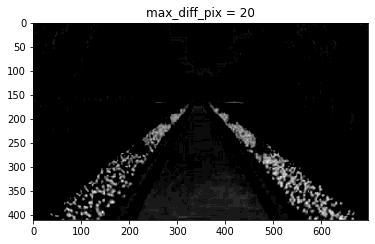

In [5]:
diff = cv2.subtract(images[1], np.uint8(255 * images[2]))
plt.imshow(diff, 'gray')
plt.title('max_diff_pix = ' + str(diff.max()));

This shows that the last 2 images is not the same! Noting that, 
- `rgb2gray` in the `skimage.color` is the same with `skimage.io.imread()` with using `as_gray = True`.

In [6]:
(si.imread(path, as_gray = True) == images[2]).all()

True

### 2.2. `RGB2HLS`

In the previous [session: HSV & its application](https://github.com/Nhan121/Some-statistical-GANs-simulations-drafts-/blob/master/Image_processing%20%26%20computer_vision/Image%20processing/Chapter1/HSV%20mode%20%26%20application.ipynb), I had represented the `RGB->HSV transformation`, in this part, we will discuss the `HLS` mode.

[Wiki](https://en.wikipedia.org/wiki/HSL_and_HSV#Use_in_image_analysis) The `HLS` or well-known as `HSL color spaces`. `HSL (hue, saturation, lightness)` and `HSV` are alternative representations of the `RGB` color model, designed in the 1970s by computer graphics researchers to more closely align with the way human vision perceives color-making attributes. In these models, colors of each hue are arranged in a radial slice, around a central axis of neutral colors which ranges from black at the bottom to white at the top.

The `HSV` representation models the way paints of different colors mix together, with the saturation dimension resembling various tints of brightly colored paint, and the value dimension resembling the mixture of those paints with varying amounts of black or white paint. The `HSL` model attempts to resemble more perceptual color models such as the `Natural Color System (NCS)` or Munsell color system, placing fully saturated colors around a circle at a lightness value of $1/2$, where a lightness value of 0 or 1 is fully black or white.

In [7]:
pixel = np.uint8([[[23, 50, 10]]])
print("RGB->HSV using OpenCV: \n\t", cv2.cvtColor(pixel, cv2.COLOR_RGB2HSV))
print("RGB->HLS using OpenCV: \n\t", cv2.cvtColor(pixel, cv2.COLOR_RGB2HLS))

RGB->HSV using OpenCV: 
	 [[[ 50 204  50]]]
RGB->HLS using OpenCV: 
	 [[[ 50  30 170]]]


$\qquad \bullet$ **`RGB` to `HLS`** transformation in `OpenCV`

$\qquad \qquad \diamond$ **Step 1.** Convert `RGB to HSV` as in [previous_course_for_OpenCV](https://github.com/Nhan121/Some-statistical-GANs-simulations-drafts-/blob/master/Image_processing%20%26%20computer_vision/Image%20processing/Chapter1/HSV%20mode%20%26%20application.ipynb)

$\qquad \qquad \diamond$ **Step 2.**

$\qquad \qquad \qquad \circ$ $H_{\text{HLS}} = H_{\text{HSV}}$

$\qquad \qquad \qquad \circ$ $L_{\text{HLS}} = \dfrac{V_{\text{HSV}}}{255} \left( 1 - \dfrac{S_{\text{HSV}}}{2} \right)$

$\qquad \qquad \qquad \circ$ $S_{\text{HLS}} = \left( \dfrac{V_{\text{HSV}} - L_{\text{HLS}}}{\min \lbrace \frac{L}{255}, 1 - \frac{L}{255} \rbrace } \right) * \textbf{1}_{\lbrace L \neq \lbrace 0, 255 \rbrace \rbrace}. $

In [8]:
H, S, V = 50, 204/255, 50
L = np.uint8(V*(1 - S/2))
print('HLS by hand-computing: (%s, %s, %s)'%(H, L, np.uint8(((V - L)/min(L/255, 1-L/255)))))

HLS by hand-computing: (50, 30, 170)


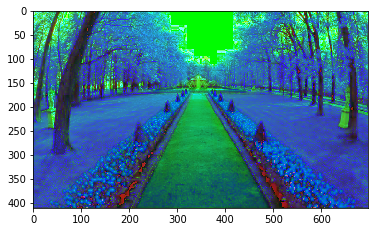

In [9]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_RGB2HLS))

### Application: Using `HLS` to extract `object` as using `HSV`

In [10]:
def compared_HSV_anothers(org_image, sub_range, object_titles, tit_flag = 'HLS', flag = cv2.COLOR_RGB2HLS):
    """
        This function is used to display and compare the object-extraction by using HSV and HLS mode
        --------------------------
        Input params:
            org_image [3D array] : the original image that contain the object you want to extract.
            sub_range [3D array ]: sample_coordinate of the object-region that you want to extract.
            object_titles (str) : name of the object and its color that you want to extract.
            tit_flag (str) : flag of color_space to compared HSV; default = HLS
            flag (params): color_flag in OpenCV; default = cv2.COLOR_RGB2HLS
        ---------------------------
        Returns:
            images of : original image, obj-extraction in HSV and HLS
            an answers of the comparision using HSV and HLS on the output-extraction
    """
    ## convert sub_range to HSV_range and HLS_range
    hsv_sub_range = cv2.cvtColor(sub_range, cv2.COLOR_RGB2HSV)
    hsl_sub_range = cv2.cvtColor(sub_range, flag)
    
    ## Create upper & lower pixel w.r.t. HSV mode
    lower_hsv = np.array([hsv_sub_range[:,:,0].min(), hsv_sub_range[:,:,1].min(), hsv_sub_range[:,:,2].min()])
    upper_hsv = np.array([hsv_sub_range[:,:,0].max(), hsv_sub_range[:,:,1].max(), hsv_sub_range[:,:,2].max()])
    
    ## Create upper & lower pixel w.r.t. HLS
    lower_hls = np.array([hsl_sub_range[:,:,0].min(), hsl_sub_range[:,:,1].min(), hsl_sub_range[:,:,2].min()])
    upper_hls = np.array([hsl_sub_range[:,:,0].max(), hsl_sub_range[:,:,1].max(), hsl_sub_range[:,:,2].max()])
    
    ## Convert your orginial image to HSV and HLS and alias by img_hsv and img_hls
    img_HSV = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    img_HLS = cv2.cvtColor(im, flag)

    ## create mask with InRange function
    mask_HSV = cv2.inRange(img_HSV, lower_hsv, upper_hsv)
    mask_HLS = cv2.inRange(img_HLS, lower_hls, upper_hls)
    
    ## convert & extract
    ext_hsv = cv2.bitwise_and(im, im, mask = mask_HSV)
    ext_hls = cv2.bitwise_and(im, im, mask = mask_HLS)
    
    ## List something to plot
    images = [org_image, ext_hsv, ext_hls]
    count_grass_hsv = (images[1] != 0).sum()
    count_grass_hls = (images[2] != 0).sum()
    titles = ['input image (Original)', 
              'Extract %s \n using HSV, total_pixel_extracted = %s'%(object_titles, count_grass_hsv),
              'Extract %s \n using %s, total_pixel_extracted = %s'%(object_titles, tit_flag, count_grass_hls)]
    
    ## answer the question:
    print("The object extracted using HSV and using %s is the same? %s"%(tit_flag, (images[1] == images[2]).all()))
    print("Is the extracted_region in HSV is more than when using %s ?? %s"%(tit_flag, (count_grass_hsv > count_grass_hls)))    
    plt.figure(figsize = (24, 7.5))
    ## display
    for k in range(3):
        plt.subplot(1,3,k+1)
        plt.imshow(images[k]); plt.title(titles[k]); plt.axis("off")        

The object extracted using HSV and using HLS is the same? False
Is the extracted_region in HSV is more than when using HLS ?? False


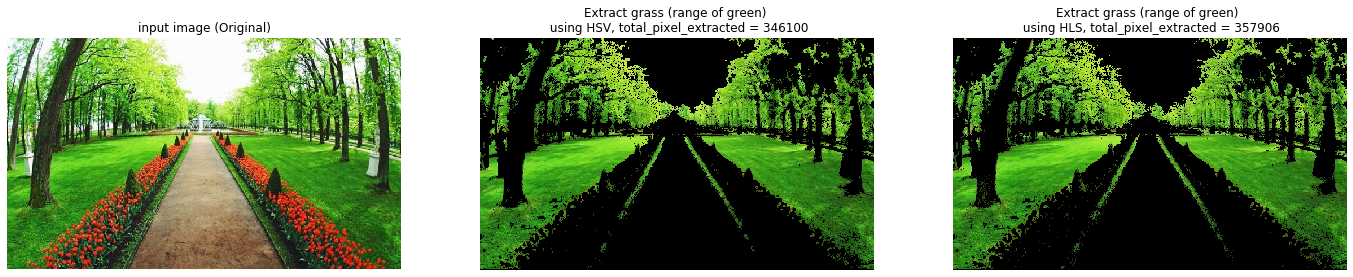

In [34]:
sub_range = im[180: 240, 150: 200]
object_titles = 'grass (range of green)'
compared_HSV_anothers(im, sub_range, object_titles)

So, using `HLS` is `better` than using `HSV` in this example to extract the `grass`!!

### 2.3. `YUV`

[YUV color space](https://en.wikipedia.org/wiki/YUV) is a color encoding system typically used as part of a color image pipeline. It encodes a color image or video taking human perception into account, allowing reduced bandwidth for chrominance components, thereby typically enabling transmission errors or compression artifacts to be more efficiently masked by the human perception than using a "direct" RGB-representation. Other color encodings have similar properties, and the main reason to implement or investigate properties of Y′UV would be for interfacing with analog or digital television or photographic equipment that conforms to certain Y′UV standards.

Readers can refer the transformation on wiki or any related document, in this part, I will introduce how to extract object using this color space.

In `OpenCV`, we can use the `flag : cv2.COLOR_RGB2YUV`

The object extracted using HSV and using YUV is the same? False
Is the extracted_region in HSV is more than when using YUV ?? False


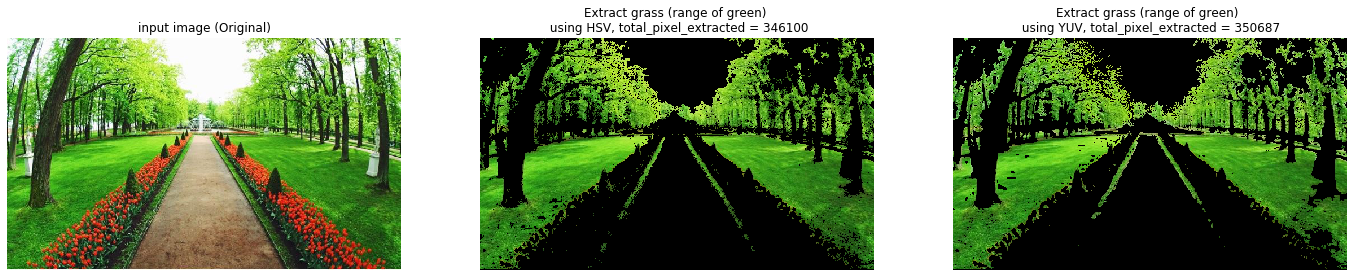

In [35]:
object_titles = 'grass (range of green)'
compared_HSV_anothers(im, sub_range, object_titles, 'YUV', cv2.COLOR_RGB2YUV)

### 2.4. YCbCr.

Reference: [link](https://en.wikipedia.org/wiki/YCbCr)

In `OpenCV`, you can use the `flag: cv2.COLOR_BGR2YCR_CB`

The object extracted using HSV and using YCbCr is the same? False
Is the extracted_region in HSV is more than when using YCbCr ?? False


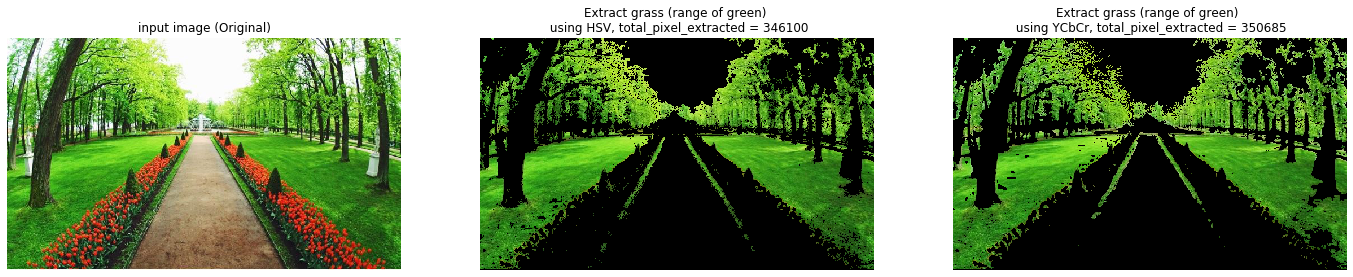

In [33]:
object_titles = 'grass (range of green)'
compared_HSV_anothers(im, sub_range, object_titles, 'YCbCr', cv2.COLOR_RGB2YCR_CB)

### PRACTICEs
#### Exercise 1. Flowers

In [ ]:
def compared_HSV_HLS_YUV_YCb(org_image, sub_range, object_titles):
    """
        This function is used to display and compare the object-extraction by using HSV, HLS, YUV and YCbCr
        --------------------------
        Input params:
            org_image [3D array] : the original image that contain the object you want to extract.
            sub_range [3D array ]: sample_coordinate of the object-region that you want to extract.
            object_titles (str) : name of the object and its color that you want to extract.
        ---------------------------
        Returns:
            images of : original image, obj-extraction in HSV and HLS
            an answers of the comparision using HSV and HLS on the output-extraction
    """
    flags = [cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2HLS, cv2.COLOR_RGB2YUV, cv2.COLOR_RGB2YCR_CB]
    for k in range(5):
        if k == 0
            image = org_img
        else:
            cvt_sub_range = cv2.cvtColor(sub_range, flags[k])
    
    lower_hsv = np.array([hsv_sub_range[:,:,0].min(), hsv_sub_range[:,:,1].min(), hsv_sub_range[:,:,2].min()])
    upper_hsv = np.array([hsv_sub_range[:,:,0].max(), hsv_sub_range[:,:,1].max(), hsv_sub_range[:,:,2].max()])
    lower_hls = np.array([hsl_sub_range[:,:,0].min(), hsl_sub_range[:,:,1].min(), hsl_sub_range[:,:,2].min()])
    upper_hls = np.array([hsl_sub_range[:,:,0].max(), hsl_sub_range[:,:,1].max(), hsl_sub_range[:,:,2].max()])
    lower_yuv = np.array([hsl_sub_range[:,:,0].min(), hsl_sub_range[:,:,1].min(), hsl_sub_range[:,:,2].min()])
    upper_yuv = np.array([hsl_sub_range[:,:,0].max(), hsl_sub_range[:,:,1].max(), hsl_sub_range[:,:,2].max()]) 

    ## Convert your orginial image to HSV and HLS and alias by img_hsv and img_hls
    img_HSV = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    img_HLS = cv2.cvtColor(im, flag)

    ## create mask with InRange function
    mask_HSV = cv2.inRange(img_HSV, lower_hsv, upper_hsv)
    mask_HLS = cv2.inRange(img_HLS, lower_hls, upper_hls)
    
    ## convert & extract
    ext_hsv = cv2.bitwise_and(im, im, mask = mask_HSV)
    ext_hls = cv2.bitwise_and(im, im, mask = mask_HLS)
    
    ## List something to plot
    images = [org_image, ext_hsv, ext_hls]
    count_grass_hsv = (images[1] != 0).sum()
    count_grass_hls = (images[2] != 0).sum()
    titles = ['input image (Original)', 
              'Extract %s \n using HSV, total_pixel_extracted = %s'%(object_titles, count_grass_hsv),
              'Extract %s \n using %s, total_pixel_extracted = %s'%(object_titles, tit_flag, count_grass_hls)]
    

    plt.figure(figsize = (24, 7.5))
    ## display
    for k in range(3):
        plt.subplot(1,3,k+1)
        plt.imshow(images[k]); plt.title(titles[k]); plt.axis("off")        

The object extracted using HSV and using HLS is the same? False
Is the extracted_region in HSV is more than when using HLS ?? True


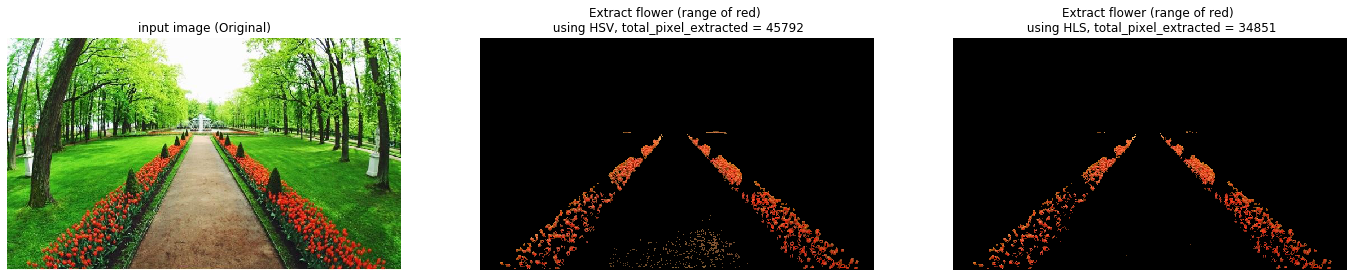

In [40]:
sub_range = im[320:328, 150:156]
object_titles = 'flower (range of red)'
compared_HSV_anothers(im, sub_range, object_titles, 'HLS', cv2.COLOR_RGB2HLS)

The object extracted using HSV and using YUV is the same? False
Is the extracted_region in HSV is more than when using YUV ?? True


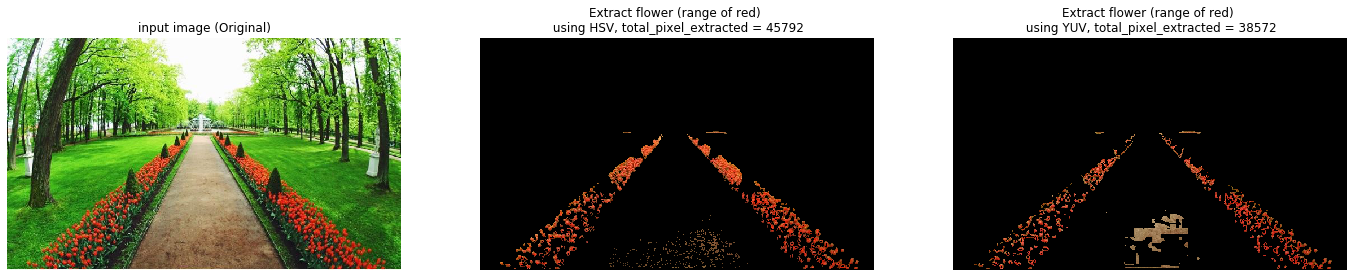

In [39]:
compared_HSV_anothers(im, sub_range, object_titles, 'YUV', cv2.COLOR_RGB2YUV)

The object extracted using HSV and using YCbCr is the same? False
Is the extracted_region in HSV is more than when using YCbCr ?? True


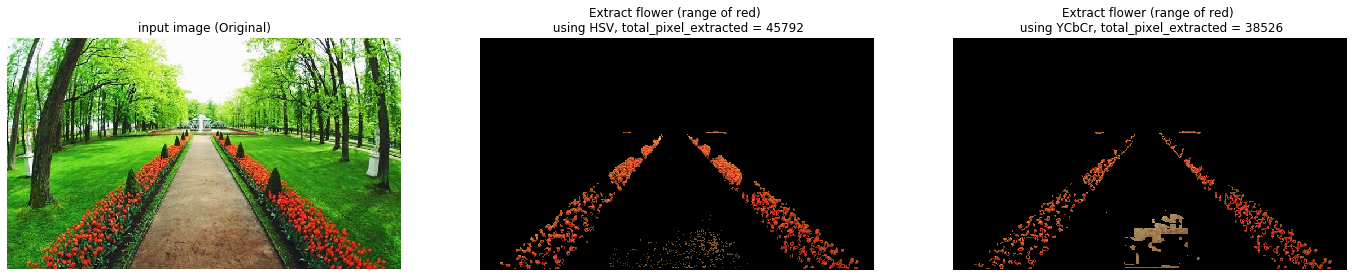

In [38]:
compared_HSV_anothers(im, sub_range, object_titles, 'YCbCr', cv2.COLOR_RGB2YCR_CB)

#### Exercise 2. Extract the clear-sky

The object extracted using HSV and using HLS is the same? False
Is the extracted_region in HSV is more than when using HLS ?? False


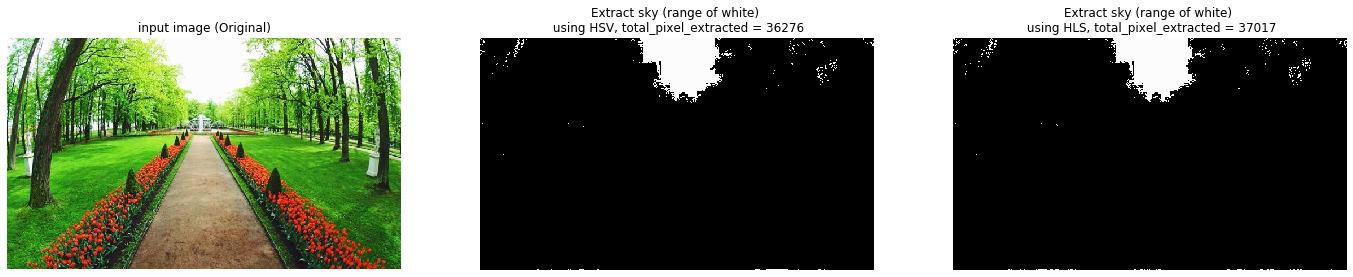

In [41]:
sub_range = im[0: 40, 300: 400]
object_titles = 'sky (range of white)'
compared_HSV_anothers(im, sub_range, object_titles, 'HLS', cv2.COLOR_RGB2HLS)

The object extracted using HSV and using YUV is the same? False
Is the extracted_region in HSV is more than when using YUV ?? True


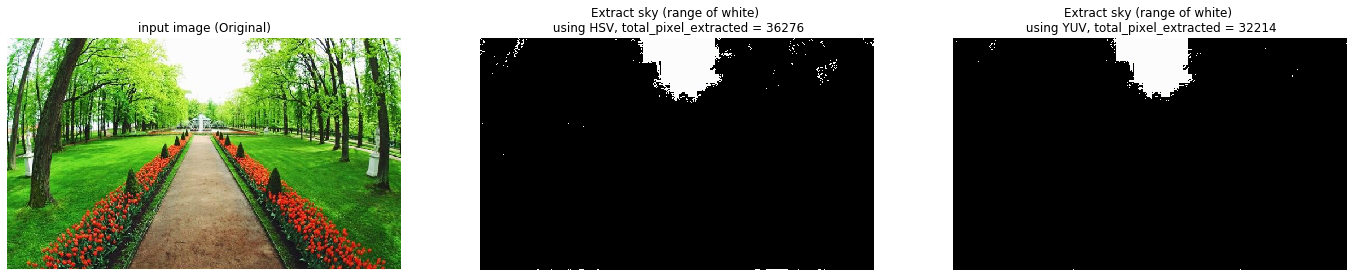

In [43]:
compared_HSV_anothers(im, sub_range, object_titles, 'YUV', cv2.COLOR_RGB2YUV)

The object extracted using HSV and using YCbCr is the same? False
Is the extracted_region in HSV is more than when using YCbCr ?? True


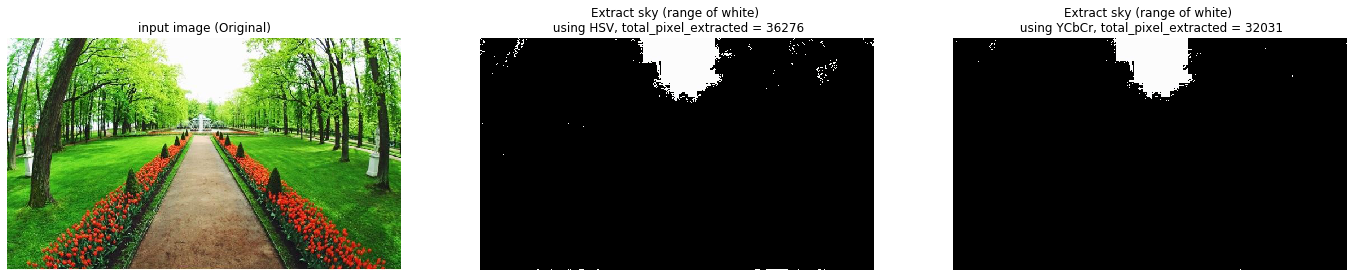

In [42]:
compared_HSV_anothers(im, sub_range, object_titles, 'YCbCr', cv2.COLOR_RGB2YCR_CB)

#### Exercise 3. Extract the `ground`

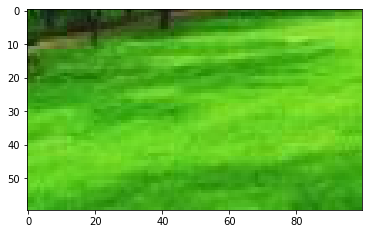

In [31]:
plt.imshow(sub_range)